#Algorithms for Massive Dataset project: Finding similar items

The goal of this project is to implement a **similar movie pair detector** from scratch. Each movie will be represented by aggregating information from various files in the dataset in a meaningful and non-trivial way.

The notebook is structured into the following sections:  

0. **Preliminary Steps** – Initial setup and data preparation.  
1. **Dataset Exploration** – Analyzing and understanding the dataset.  
2. **TF-IDF Measure** – Computing term frequency-inverse document frequency for feature representation.  
3. **The Inverted Index Structure** – Building an efficient indexing structure for token retrieval.  
4. **Cosine Distance** – Measuring similarity between movie representations.  
5. **Locality Sensitive Hashing with Cosine Similarity** – Constructing hash table for efficiency movie comparison
6. **Similarity Detection on the Movie Dataset** – Identifying and linking similar movie pairs.  
6. **Experiments and Evaluation** – Evaluating results and insights.


## 0. Preliminary Steps
In this project, **Python** 3.11 version is used along with the **Apache Spark API** 3.5.4 version, a framework designed for processing **Big Data** distributed across multiple clusters.  

### Sections Overview:  

- **Section 0.1:** **Importing** all necessary libraries required for data processing and analysis and defining the required paths for dataset storage access.
- **Section 0.2:** **Downloading** the dataset and preparing it for further processing.  

### 0.1. Environment Initialization


In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')

In [2]:
import sys
import os
import math
import re
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from scipy.sparse import csr_matrix
from itertools import combinations

FULL_DATA_DIR = 'dataset/full_dataset/'
SMALL_DATA_DIR = 'dataset/small_dataset/'

# Change depending on the small or big dataset
#base_dir = os.path.join(FULL_DATA_DIR)
base_dir = os.path.join(SMALL_DATA_DIR)

###0.2. Dataset Download

In [3]:
# Dataset Download
!mkdir -p dataset
!mkdir -p dataset/full_dataset
!mkdir -p dataset/small_dataset

!kaggle datasets download -d gsimonx37/letterboxd --file actors.csv -p dataset/full_dataset
!kaggle datasets download -d gsimonx37/letterboxd --file countries.csv -p dataset/full_dataset
!kaggle datasets download -d gsimonx37/letterboxd --file crew.csv -p dataset/full_dataset
!kaggle datasets download -d gsimonx37/letterboxd --file genres.csv -p dataset/full_dataset
!kaggle datasets download -d gsimonx37/letterboxd --file languages.csv -p dataset/full_dataset
!kaggle datasets download -d gsimonx37/letterboxd --file movies.csv -p dataset/full_dataset
!kaggle datasets download -d gsimonx37/letterboxd --file posters.csv -p dataset/full_dataset
!kaggle datasets download -d gsimonx37/letterboxd --file releases.csv -p dataset/full_dataset
!kaggle datasets download -d gsimonx37/letterboxd --file studios.csv -p dataset/full_dataset
!kaggle datasets download -d gsimonx37/letterboxd --file themes.csv -p dataset/full_dataset

!unzip -o 'dataset/full_dataset/*.zip' -d dataset/full_dataset && rm dataset/full_dataset/*.zip

Dataset URL: https://www.kaggle.com/datasets/gsimonx37/letterboxd
License(s): GPL-3.0
100% 76.0M/76.3M [00:00<00:00, 108MB/s]
100% 76.3M/76.3M [00:00<00:00, 118MB/s]
Dataset URL: https://www.kaggle.com/datasets/gsimonx37/letterboxd
License(s): GPL-3.0
  0% 0.00/2.39M [00:00<?, ?B/s]
100% 2.39M/2.39M [00:00<00:00, 117MB/s]
Dataset URL: https://www.kaggle.com/datasets/gsimonx37/letterboxd
License(s): GPL-3.0
 92% 43.0M/46.5M [00:00<00:00, 94.3MB/s]
100% 46.5M/46.5M [00:00<00:00, 91.2MB/s]
Dataset URL: https://www.kaggle.com/datasets/gsimonx37/letterboxd
License(s): GPL-3.0
  0% 0.00/3.04M [00:00<?, ?B/s]
100% 3.04M/3.04M [00:00<00:00, 123MB/s]
Dataset URL: https://www.kaggle.com/datasets/gsimonx37/letterboxd
License(s): GPL-3.0
  0% 0.00/3.67M [00:00<?, ?B/s]
100% 3.67M/3.67M [00:00<00:00, 52.6MB/s]
Dataset URL: https://www.kaggle.com/datasets/gsimonx37/letterboxd
License(s): GPL-3.0
 93% 99.0M/106M [00:00<00:00, 130MB/s]
100% 106M/106M [00:00<00:00, 117MB/s] 
Dataset URL: https://www.ka

## 1. Dataset Exploration  

The dataset consists of **10 CSV files** containing information about films. Below are the files along with their respective attributes:  

- **actors.csv**: Id, Name, Role  
- **countries.csv**: Id, Country  
- **crew.csv**: Id, Role, Name  
- **genres.csv**: Id, Genre  
- **languages.csv**: Id, Type, Language  
- **movies.csv**: Id, Name, Date, Tagline, Description, Minute, Rating  
- **posters.csv**: Id, Link  
- **releases.csv**: Id, Country, Date, Type, Rating  
- **studios.csv**: Id, Studio  
- **themes.csv**: Id, Theme  

### Sections Overview:  

- **Section 1.1:** The dataset is **subsampled** to reduce the computational cost of the algorithms, creating a smaller dataset.  
- **Section 1.2:** The datasets are **organized** into two directories:  
  - `dataset/small_dataset` (subsampled)  
  - `dataset/full_dataset` (original)  
- **Section 1.3:** The dataset is **loaded** into the distributed filesystem while ensuring the validity of each data entry.  
- **Section 1.4:** The dataset is **encoded** using the **Bag of Words** approach, where the **Id** serves as the key, and the value is a list of tokens.

###1.1. Dataset Sampling

To create the subsampled dataset, the `sample` function is used. The process begins with **movies.csv**, where only **1% of the records** are selected. The corresponding **movie IDs** from this sample are then extracted and used to **filter** all other files, ensuring that only records related to the selected movies are retained.

In [4]:
# Initialize Spark session
spark = SparkSession.builder.appName("SubsampleDataset").getOrCreate()

# Load datasets
movies = spark.read.csv(FULL_DATA_DIR+"movies.csv", header=True, inferSchema=True)
actors = spark.read.csv(FULL_DATA_DIR+"actors.csv", header=True, inferSchema=True)
countries = spark.read.csv(FULL_DATA_DIR+"countries.csv", header=True, inferSchema=True)
crew = spark.read.csv(FULL_DATA_DIR+"crew.csv", header=True, inferSchema=True)
genres = spark.read.csv(FULL_DATA_DIR+"genres.csv", header=True, inferSchema=True)
languages = spark.read.csv(FULL_DATA_DIR+"languages.csv", header=True, inferSchema=True)
posters = spark.read.csv(FULL_DATA_DIR+"posters.csv", header=True, inferSchema=True)
releases = spark.read.csv(FULL_DATA_DIR+"releases.csv", header=True, inferSchema=True)
studios = spark.read.csv(FULL_DATA_DIR+"studios.csv", header=True, inferSchema=True)
themes = spark.read.csv(FULL_DATA_DIR+"themes.csv", header=True, inferSchema=True)
id_names = movies.select("Id", "Name")

# Step 1: Sample movies
sampled_movies = movies.sample(withReplacement=False, fraction=0.01, seed=42)
sampled_ids = sampled_movies.select("Id").distinct()

# Step 2: Filter related datasets
sampled_actors = actors.join(sampled_ids, "Id", "inner")
sampled_countries = countries.join(sampled_ids, "Id", "inner")
sampled_crew = crew.join(sampled_ids, "Id", "inner")
sampled_genres = genres.join(sampled_ids, "Id", "inner")
sampled_languages = languages.join(sampled_ids, "Id", "inner")
sampled_posters = posters.join(sampled_ids, "Id", "inner")
sampled_releases = releases.join(sampled_ids, "Id", "inner")
sampled_studios = studios.join(sampled_ids, "Id", "inner")
sampled_themes = themes.join(sampled_ids, "Id", "inner")

# Step 3: Save the subsampled datasets into a single CSV file
sampled_movies.coalesce(1).write.csv(SMALL_DATA_DIR+"temp/movies.csv", header=True, mode="overwrite")
sampled_actors.coalesce(1).write.csv(SMALL_DATA_DIR+"temp/actors.csv", header=True, mode="overwrite")
sampled_countries.coalesce(1).write.csv(SMALL_DATA_DIR+"temp/countries.csv", header=True, mode="overwrite")
sampled_crew.coalesce(1).write.csv(SMALL_DATA_DIR+"temp/crew.csv", header=True, mode="overwrite")
sampled_genres.coalesce(1).write.csv(SMALL_DATA_DIR+"temp/genres.csv", header=True, mode="overwrite")
sampled_languages.coalesce(1).write.csv(SMALL_DATA_DIR+"temp/languages.csv", header=True, mode="overwrite")
sampled_posters.coalesce(1).write.csv(SMALL_DATA_DIR+"temp/posters.csv", header=True, mode="overwrite")
sampled_releases.coalesce(1).write.csv(SMALL_DATA_DIR+"temp/releases.csv", header=True, mode="overwrite")
sampled_studios.coalesce(1).write.csv(SMALL_DATA_DIR+"temp/studios.csv", header=True, mode="overwrite")
sampled_themes.coalesce(1).write.csv(SMALL_DATA_DIR+"temp/themes.csv", header=True, mode="overwrite")

print("Subsampling completed.")

Subsampling completed.


###1.2. Folder organization

In [5]:
dir_names = []
file_names = []
root_dir = 'dataset/small_dataset/temp/'

for root, dirs, files in os.walk(root_dir):
    # root: current directory path
    # dirs: list of subdirectories in the current directory
    # files: list of files in the current directory

    # Iterate over each subdirectory in the current directory
    for d in dirs:
        dir_names.append(d);
    for f in files:
        if f.endswith('.csv'):
            file_names.append(f)

dirs_and_files = zip(dir_names, file_names)

for d, f in dirs_and_files:
    os.rename(root_dir+d+"/"+f, SMALL_DATA_DIR+d)

!rm -rf dataset/small_dataset/temp

print("Folder organization completed")

Folder organization completed


### 1.3. Dataset Preprocessing

In this section, all **CSV files** are loaded into the **distributed dataset**.  

Each record in the **RDD** is represented in the following format: `[('MovieId1', 'attribute1', 'attribute2', ..., 'attributeN'), ('MovieId2', 'attribute1', 'attribute2', ..., 'attributeN'), ...]`.  
In this way it is possible to filter out an entire columns of a specific attribute if not needed.

Each file is loaded individually using the `load_data` function, which calls the `parse_data` function. `parse_data` applies the `parse_datafile_line` function to each entry in the file which ensures data validity by:

- Verifying that each entry follows the correct pattern (MovieId is mandatory, while other attributes are optional),
- Removing quotation marks using the `remove_quotes` function,
- Retaining only valid records in the **RDD**.

Each dataset has its own specific pattern, and while the `MovieId` remains mandatory, other fields may also be required depending on the dataset.

In [6]:
GENERIC_PATTERN = '^([^,]+),([^,]*),([^,]*),([^,]*),\"([^\"]*)\",([^,]*),([^,]*)$'
ACTORS_PATTERN = '^(.+),(.+),(.+)'
COUNTRIES_PATTERN = '^(.+),(.+)'
CREW_PATTERN = '^(.+),(.*),(.+)'
GENRES_PATTERN = '^(.+),(.+)'
LANGUAGES_PATTERN = '^(.+),(.*),(.+)'
MOVIES_PATTERN = '^([^,]+),([^,]+),([^,]*),([^,]*),\"([^\"]+)\",([^,]*),([^,]*)$'
POSTERS_PATTERN = '^(.+),(.+)'
RELEASES_PATTERN = '^(.+),(.+),(.+),(.+),(.+)'
STUDIOS_PATTERN = '^(.+),(.+)'
THEMES_PATTERN = '^(.+),(.+)'

def remove_quotes(s):
    """ Remove quotation marks from an input string

    Args:
        s (str): input string that might have the quote "" characters

    Returns:
        str: a string without the quote characters
    """
    return ''.join(i for i in s if i!='"')


def parse_datafile_line(datafile_line, datafile_pattern):
    """ Parse a line of the data file using the specified regular expression
    pattern

    Args:
        datafileLine (str): input string that is a line from the data file

    Returns:
        str: a string parsed using the given regular expression and without
             the quote characters
    """

    match = re.search(datafile_pattern, datafile_line.decode('utf-8'))
    if match is None:
        #print('Invalid datafile line: {}'.format(datafile_line))
        return (datafile_line, -1)
    elif match.group(1) == 'id':
        #print('Header datafile line: {}'.format(datafile_line))
        return (datafile_line, 0)
    else:
        product = [remove_quotes(group) for group in match.groups()[1:]]
        return ((remove_quotes(match.group(1)), *product), 1)

def parse_data(filename, datafile_pattern):
    """ Parse a data file

    Args:
        filename (str): input file name of the data file

    Returns:
        RDD: a RDD of parsed lines
    """
    return (sc
            .textFile(filename, 4, 0)
            .map(lambda line: parse_datafile_line(line, datafile_pattern))
            )

def load_data(path, datafile_pattern):
    """ Load a data file

    Args:
        path (str): input file name of the data file

    Returns:
        RDD: a RDD of parsed valid lines
    """

    filename = os.path.join(base_dir, path)
    raw = parse_data(filename, datafile_pattern).cache()
    #print('Loading {} in the Distributed Dataset'.format(path))

    failed = (raw
              .filter(lambda s: s[1] == -1)
              .map(lambda s: s[0]))
    """
    for line in failed.take(10):
        #print('{} - Invalid datafile line: {}'.format(path, line))
        print(line)
    """
    valid = (raw
             .filter(lambda s: s[1] == 1)
             .map(lambda s: s[0])
             .cache())
    """
    print('{} - Read {} lines, successfully parsed {} lines, '
           'failed to parse {} lines'.format(path,
                                             raw.count(),
                                             valid.count(),
                                             failed.count()))
    """
    return valid


###1.4. Bag of Words

After the initial preprocessing, the documents are represented using the **Bag of Words** model. This model encodes each document as a set of words—or more precisely, tokens—appearing in it, without considering word order or grammar.  

This transformation is performed using the `tokenize` function, which takes a **key-value pair** as input and outputs a **key-token list pair**, where:  
- The **key** remains the movie ID.  
- The **value** is converted into a **list of tokens** extracted from the original text.

Inside the string to be converted, there may be stop words, which are words that frequently appear in written texts of a given language and do not carry significant informational content. For this reason, the `tokenize` function detects and removes them.

In [7]:
stopwords = {'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'did', 'do', 'does', 'doing', 'don', 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'itself', 'just', 'me', 'more', 'most', 'my', 'myself', 'no', 'nor', 'not', 'now', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 's', 'same', 'she', 'should', 'so', 'some', 'such', 't', 'than', 'that', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'you', 'your', 'yours', 'yourself', 'yourselves'}

split_regex = r"[a-zA-Z0-9]+(?:[-'][a-zA-Z0-9]+)*"

def tokenize(string):
    """ An implementation of input string tokenization that excludes stopwords

    Args:
        string (str): input string

    Returns:
        list: a list of tokens without stopwords
    """
    return [s for s in re.findall(split_regex, string.lower()) if s not in stopwords]


## 2. The Inverted Index structure

An **inverted index** is a data structure commonly used to efficiently search and retrieve documents that contain a specific token (or word). It maps tokens (terms) to the list of documents or records that contain them, rather than mapping documents to the tokens they contain.

### Structure of an Inverted Index:

1. **Tokens (Terms):** The unique words (or tokens) found in a collection of documents.
2. **Document IDs (or references):** These are identifiers that refer to the documents that contain the token.

The idea behind an inverted index is that instead of scanning through every document to find a token, for each token is stored a list of documents in which it appears. With this structure it is easy to quickly retrieve documents that contain a specific token without having to look through every document individually.

### Sections Overview:  
- **Section 2.1: The Invert function**  

- **Section 2.2: The Swap function**  







###2.1. The Invert function

To create inverted indices, the first step is to implement a function called `invert`. This function, given a pair `(MovieId, token list)`, returns a list of pairs `(token, MovieId)`.

The `invert` function can then be used to convert entire datasets into their corresponding inverted indices.

In [8]:
def invert(record):
    """ Invert (MovieId, token vector) to a list of (token, MovieId)

    Args:
        record: a pair, (MovieId, token vector)

    Returns:
        pairs: a list of pairs of token to MovieId
    """

    pairs = [(f, record[0]) for f in record[1]]
    return pairs


###2.2. The Swap function

The `swap` function swaps the positions of the token and its associated information in a given record. This function, given a pair `(token, (MovieId1, MovieId2))`, returns a pair `((MovieId1, MovieId2), token)`.
Basically, it reverses their positions so that the movie pair becomes the key, and the token becomes the value.

In [9]:
def swap(record):
    """ Swap (token, (MovieId1, MovieId2)) to ((MovieId1, MovieId2), token)

    Args:
        record: a pair, (token, (MovieId1, MovieId2))

    Returns:
        pair: ((MovieId1, MovieId2), token)
    """
    token = record[0]
    keys = record[1]
    return (keys, token)


##3. TF.IDF Measure
To improve the technique based on the bag of words, it is important to assign different weights to the tokens in a document to reflect the relevance of specific terms. An effective heuristic to identify these terms is the TF.IDF (Term Frequency times Inverse Document Frequency) measure, obtained by multiplying two indicators defined below.

### Sections Overview:  
- **Section 3.1: Term Frequency**  
The Term Frequency gives higher weight to tokens that tend to occur multiple times within the same document. It is calculated as the relative frequency of the token in the document.
If \\(t\\) is the number of occurrencies of a token in \\(d\\) which is the number of total occurrencies, the Term Frequency of \\(t\\) in \\(d\\) is \\(\mathrm{TF}(t, d) = \frac{t}{d}\\).

- **Section 3.2: Inverse Document Frequency**  
The Inverse Document Frequency assigns higher weight to tokens that rarely occur across the dataset. The formula is:
\\(\mathrm{IDF}(t) = ln(\frac{N}{n(t)}\\)), where \\(N\\) &egrave; is the total number of documents and \\(n(t)\\) is the number of documents that contains \\(t\\). The logarithm is applied in the Inverse Document Frequency (IDF) formula to scale the values and prevent extremely large weights for rare words.

- **Section 3.3: TF.IDF**  
The TF.IDF measure of a token \(t\) in a document \(d\) is the product of Term Frequency and Inverse Document Frequency.
A high TF.IDF indicates a token that frequently appears in a specific document but rarely in others, and thus, more weight will be assigned, in computing the similarity between two documents, to the fact that both contain a term with a high TF.IDF value.



###3.1. Term Frequency
The function `tf`, given a list of tokens, returns a dictionary mapping each token to its corresponding Term Frequency.
The function works as follows:
- Create an empty dictionary;
- For each token in the list passed as an argument, add it as a key with a value of 1 if it is not already in the dictionary; otherwise, increment the associated value by one;
- For each token in the dictionary, divide the associated value by the total number of tokens in the list passed as arguments

In [10]:
def tf(tokens):
    """ Compute TF

    Args:
        tokens (list of str): input list of tokens from tokenize

    Returns:
        dictionary: a dictionary of tokens to its TF values
    """
    val = {}
    for t in tokens:
        if t in val:
            val[t] += 1
        else:
            val[t] = 1.0
    for t in val:
        val[t] /= len(tokens)
    return val

###3.2. Inverse Document Frequency
The function `idfs` assigns the Inverse Document Frequency (IDF) value to each token appearing in a corpus of documents, returning an RDD of pairs (𝑡, 𝑖), where 𝑡 and 𝑖 are, respectively, a token and its corresponding IDF value.

The function will execute the following steps:
- Calculate 𝑁, the total number of documents in the corpus;
- Create an RDD that, for each document in the corpus, contains all the unique tokens it includes;
- For each unique token 𝑡, count how many times it appears in the corpus to compute 𝑛(𝑡) and subsequently the Inverse Document Frequency for
𝑡.


In [11]:
def idfs(corpus):
    """ Compute IDF

    Args:
        corpus (RDD): input corpus

    Returns:
        RDD: a RDD of (record ID, IDF value)
    """

    N = corpus.count() * 1.0
    unique_tokens = corpus.map(lambda s: list(set(s[1])))
    token_count_pair_tuple = unique_tokens.flatMap(lambda t: [(s, 1) for s in t]) # (token, 1)
    token_sum_pair_tuple = token_count_pair_tuple.reduceByKey(lambda a, b: a+b)   # (token, count(token))
    return token_sum_pair_tuple.map(lambda s: (s[0], math.log(N/s[1])))   # (token, idfs(token))


###3.3. TF.IDF
The function `tfidf`, given a list of tokens in a document and the dictionary returned by idfs, returns a dictionary mapping the tokens in the list to their corresponding TF.IDF values.

The function will:
- Calculate the TF for all tokens in the list;
- Create a dictionary where each token (the key) is mapped to its TF value multiplied by its corresponding IDF value

In [12]:
def tfidf(tokens, idfs):
    """ Compute TF-IDF

    Args:
        tokens (list of str): input list of tokens from tokenize
        idfs (dictionary): record to IDF value

    Returns:
        dictionary: a dictionary of records to TF-IDF values
    """
    tfs = tf(tokens)
    tf_idf_dict = {t: tfs[t]*idfs[t] for t in tokens}
    return tf_idf_dict

##4. Cosine Similarity

The measure of similarity between documents used in this project is the **cosine similarity**, which interprets two objects as directions in a space and calculates the cosine of the angle formed by these directions.  When the angle between two vectors is small the similarity is high and vice versa.

The documents are encoded as directions in space, and therefore as vectors. Each possible token in our corpus represents a dimension: a generic document will have as the component in the dimension corresponding to a token the corresponding value of the TF.IDF measure.
The following sections implement this similarity measurement.

##Sections Overview

- **Section 4.1: Dot product and Norm**  
In this section the dot product \\( a \cdot b \\) and the norm \\( \| a \| \|  b \|   \\) are computed.

- **Section 4.2: Cosine Similarity**  
In this section the angle between two vectors is computed. This can be done easily by recalling that \\( a \cdot b = \| a \| \| b \| \cos \theta \\), where \\( a \cdot b \\) denotes the dot product of two vectors \\(a\\) and \\(b\\), \\(\theta\\) is the angle between these vectors, and \\(\| a \|\\) denotes the norm of \\(a\\). Therefore:

$$ \mathrm{sim}(a, b) = \cos \theta = \frac{a \cdot b}{\|a\| \|b\|} = \frac{\sum a_i b_i}{\sqrt{\sum a_i^2} \sqrt{\sum b_i^2}} .$$

- **Section 4.3: Fast Cosine Similarity**
In this section a more efficient algorithm for computing the cosine similarity is presented.
This function operates on pre-tokenized and preprocessed data, avoiding repetitive computations and uses broadcast variables.  



###4.1. Dot Product and Norm
- The function `dotprod` takes as arguments the dictionaries representing two sparse vectors and returns their corresponding dot product (in this case, equal to the sum of the products of the values corresponding to keys that appear in both dictionaries). In this case the keys of the dictionary are the tokens and the values are their TF.IDF values.

- The function `norm` returns the norm of a sparse vector passed as a dictionary (calculating it as the square root of the dot product of the vector with itself).

In [13]:
import math

def dotprod(a, b):
    """ Compute dot product

    Args:
        a (dictionary): first dictionary of record to value
        b (dictionary): second dictionary of record to value

    Returns:
        dotProd: result of the dot product with the two input dictionaries
    """

    return sum([a[t] * b[t] for t in a if t in b])


def norm(a):
    """ Compute square root of the dot product

    Args:
        a (dictionary): a dictionary of record to value

    Returns:
        norm: a dictionary of tokens to its TF values
    """
    return math.sqrt(dotprod(a, a))


###4.2. Cosine Similarity
The function `cossim` returns the cosine similarity between the two sparse vectors specified as arguments, using the formula provided above and the functions defined in the previous points.

The function `cosine_similarity`, given two strings representing documents and a dictionary of IDF values for a corpus, computes and returns the cosine similarity between the corresponding vectors in the token space. The necessary steps are:
- Tokenize the two strings and then use them along with the dictionary to call the tf.idf function
- Call the cossim function passing the dictionary with the tokens and their TF.IDF value and then return the similarity between them.

In [14]:
def cossim(a, b):
    """ Compute cosine similarity

    Args:
        a (dictionary): first dictionary of record to value
        b (dictionary): second dictionary of record to value

    Returns:
        cossim: dot product of two dictionaries divided by the norm of the first dictionary and
                then by the norm of the second dictionary
    """
    return dotprod(a, b)/(norm(a) * norm(b))


def cosine_similarity(string1, string2, idfs_dictionary):
    """ Compute cosine similarity between two strings

    Args:
        string1 (str): first string
        string2 (str): second string
        idfsDictionary (dictionary): a dictionary of IDF values

    Returns:
        cossim: cosine similarity value
    """

    w1 = tfidf(tokenize(string1), idfs_dictionary)
    w2 = tfidf(tokenize(string2), idfs_dictionary)
    return cossim(w1, w2)


###4.3. Fast Cosine Similarity
The function `fast_cosine_similarity`
takes as input a record in the format `((MovieId1, MovieId2), tokens list)` and:
- Computes the corresponding dot product.
- The result is then divided by the norm of the vectors describing the two documents involved.

The function returns a pair where the key is `(MovieId1, MovieId2)` and the value is the computed similarity score.
This function is more efficient than the last one because the tf-idf weights and the norm are precomputed and stored in two broadcast variables. This reduces communication costs between nodes and improves the performance because each worker has local access to the data.

In [15]:
def fast_cosine_similarity(record, tfidf_combined_broadcast, norm_combined_broadcast):
    """Compute Cosine Similarity between two movies using Broadcast variables.

    Args:
        record: ((movie1_id, movie2_id), common_tokens)
        joined_data_weights_broadcast: Broadcast variable containing TF-IDF weights.
        joined_data_norm_broadcast: Broadcast variable containing precomputed norms.

    Returns:
        pair: ((movie1_id, movie2_id), cosine similarity value)
    """

    movie1_id, movie2_id = record[0]  # Extract movie IDs
    common_tokens = record[1]         # Extract common tokens

    # Compute dot product using TF-IDF weights from the broadcast variable
    dot_product = sum(
        tfidf_combined_broadcast.value[movie1_id].get(t, 0) *
        tfidf_combined_broadcast.value[movie2_id].get(t, 0)
        for t in common_tokens
    )

    # Get precomputed norms from the broadcast variable
    norm1 = norm_combined_broadcast.value.get(movie1_id, 0)
    norm2 = norm_combined_broadcast.value.get(movie2_id, 0)

    # Compute the cosine similarity
    cosine_similarity = dot_product / (norm1 * norm2)

    return ((movie1_id, movie2_id), cosine_similarity)


## **5. Locality-Sensitive-Hashing for Cosine Similarity**
Finding similar movies efficiently in a large dataset can be computationally expensive if every pair needs to be compared.
To address this challenge, the **Locality-Sensitive Hashing (LSH)** is used. It is a technique that approximates nearest neighbor search by ensuring that similar items are mapped to the same bucket with high probability.  
LSH is particularly useful for **cosine similarity**, where the goal is to identify vectors (representing movies) that have small angular distances.

### **How LSH Works for Cosine Similarity**
1. **Generate Random Hyperplanes:**  
   - Create multiple random hyperplanes that pass through the origin in the vector space.   
   - Each hyperplane acts as a separator, dividing the space into two halves.  
   - The function used is to create the hyperplanes is: `generate_random_hyperplanes`.

2. **Hashing Movie Vectors:**  
   - Each movie is represented as a high-dimensional sparse vector containing the TF-IDF features.  
   - The vector is projected onto each hyperplane:  
     - If the projection is **positive**, assign **1**.  
     - If the projection is **negative**, assign **0**.  
   - This results in a unique **binary hash** for each vector.
   - The function used to compute the binary hashes is: `compute_hashes`; instead the function used to create a tf.idf sparse vector is `to_sparse_vector`

3. **Constructing the Hash Table:**  
   - Convert the binary hash into an integer to use as a bucket index.  
   - Store the movie IDs in a **hash table**, where each bucket contains movies with the same hash values.  
   - The function used to convert binary hash values into integers is: `bin_to_hash`

This is an **Efficient Similarity Search** because: instead of comparing all pairs, only movies within the same bucket are compared using cosine similarity. This reduces significantly  the number of required distance computations.  

### **Sparse Vector Structure**
Each movie is represented by its TF-IDF values. These values are stored in a Compressed Sparse Row (CSR) vectors for each film. This structure is efficient for high dimensional data since it store only non zero values.
The CSR matrix consists of three main array:
- Data array: contains the non-zero value
- Column indices: store the column indices to the values in data
- Row counts: cumulative count of non-zero values per row

### ***Hash table size***
The size of the hash table, meaning the number of available buckets, depends on the number of hash functions (hyperplanes) used. In particular, if 'b' hyperplanes are used, the number of possible buckets is $2^b$.
A small 'b' results in fewer buckets, causing more movies to collide  and increasing the rate of false positives (movies with low similarity are hashed in the same bucket). On the other hand, a large 'b' creates many buckets, but only a subset will be populated and fewer movies with high similarity will be grouped together in the same bucket.
Choosing the appropriate hash table size depends on the dimension of the dataset and the number of features. For large datasets with a lot of features, a higher number of buckets helps minimize collisions and improve precision, while for smaller datasets, fewer buckets are needed to avoid sparsity.

In [16]:
def to_sparse_vector(tfidf_vector, vocab_size, token_index_broadcast):
    """ Convert TF-IDF row to a sparse row.

    Args:
        tfidf_vector: a dictionary of TF-IDF values
        vocab_size: the size of the tf.idf dictionary

    Returns:
        csr_matrix: a sparse matrix (in this case a vector) of TF-IDF values
    """
    token_index = token_index_broadcast.value
    indices = [token_index[token] for token in tfidf_vector if token in token_index]
    values = [tfidf_vector[token] for token in tfidf_vector if token in token_index]
    return csr_matrix((values, ([0] * len(indices), indices)), shape=(1, vocab_size))


def generate_random_hyperplanes(dim, num_hyper):
    """ Generate a matrix of random hyperplanes. Shape: (dim, num_hyper)

    Args:
        dim (int): the dimension of the hyperplanes
        num_hyper (int): the number of hyperplanes to generate

    Returns:
        numpy.ndarray: a matrix(dim, num_hyper) of random hyperplanes
    """
    np.random.seed(42)
    return np.random.randn(dim, num_hyper)


def compute_hashes(vector, hyperplanes):
    """ Compute hash values (in binary form 0 & 1) for all tf.idf vector using matrix multiplication

    Args:
        vector (numpy.ndarray): the sparse tf.idf vector
        hyperplanes (numpy.ndarray): a matrix of hyperplanes

    Returns:
        numpy.ndarray: an array of binary hash values
    """
    return (vector.dot(hyperplanes) >= 0).astype(int)


def bin_to_int(hash_vector):
    """ Convert binary hash values into integers for efficient storage.

    Args:
        hash_matrix (numpy.ndarray): a matrix of binary hash values

    Returns:
        numpy.ndarray: a vector of integers representing the hash values
    """
    num_hashes = hash_vector.shape[1] # Col numbers
    powers_of_two = 1 << np.arange(num_hashes - 1, -1, step=-1)    # [1<<4, 1<<3, 1<<2, 1<<1, 1<<0] -> [array([16, 8, 4, 2, 1])]
    #integer_bucket = (hash_vector.dot(powers_of_two)).item()      # Converting the binary bukets into integer value

    return int(hash_vector.dot(powers_of_two))

## **6. Similarity Detection on the Movie Dataset**  

In this project, the goal is to identify pairs of similar movies by leveraging the functions defined in the previous sections.

The key steps in the similarity detection process are outlined below:

#### 1. **Dataset Preparation**
- ##### 1.1. **Load the CSV files**  
 Load the CSV files (like actors.csv, genres.csv, etc.) into the distributed system. The format of each record is the following: `('MovieId', 'Attribute1', 'Attribute2',..., 'AttributeN')` and they are saved in a Resilient Distributed Dataset (RDD).
- ##### 1.2. **Convert the data format**  
 Each map task convert each data entry from `('MovieId', 'Attribute1',...,'AttributeN')` format to `('MovieId', [token list])` format (Bag of Words). This involves processing the relevant fields (e.g., title, description, genres, etc.) to create a tokenized list for each movie.
- ##### 1.3. **Create a Combined Dataset**
   Combine the relevant RDD (e.g., movies, genres, actors..) into a single RDD (if needed). This resulting dataset will facilitate efficient processing and comparison of movie records.  
   The data format is the same: `('MovieId', [token list])`

#### 2. **Compute the TF-IDF values**
- ##### 2.1. **Compute Inverse Document Frequency (IDF) Values**
   - Calculate the Inverse Document Frequency (IDF) values for the entire Combined Dataset. The IDF is used to weigh terms based on their frequency across documents, helping to highlight important (less common) words.
   - Store the computed IDF values as a broadcast variable. Broadcast variables in Spark are sent to the workers only once and stored locally for quick access, optimizing the computation process.
   - The data format is: `{'token1': idfsToken1, 'token2':idfsToken2, ...} `.

- ##### 2.2. **Apply TF-IDF Transformation**
   - Use the previously computed IDF values to perform a Term Frequency-Inverse Document Frequency (TF-IDF) transformation. This process generates an RDD that maps each `MovieId` to a dictionary of tokens, where each token is associated with its corresponding TF-IDF measure. The TF-IDF measure helps to evaluate the importance of each token in relation to the Combined Dataset.
   - The data format is: `[('MovieId1', {'token1':idfsToken1, 'token2':idfsToken2, ...}), ..., ('MovieId2', {'token1':idfsToken1, 'token2':idfsToken2, ...})]`  

#### 3. **Apply the Locality-Sensitive-Hashing technique**
 - ##### 3.1. **Compute the sparse TF-IDF Matrix**: the TF-IDF dataset computed in 2.2 is converted into a Compressed Sparse Row (CSR) matrix used to compute the hashes. More specifically, each record is transformed by the map task in a csr vector.
 - ##### 3.2. **Compute the hyperplanes**: the random hyperplanes matrix is computed and broadcasted to each worked node in the system for efficient computations.
 - ##### 3.3. **Compute the hash values**: for each movie vector the hash value is computed and converted from a binary number to an integer.
 - ##### 3.4. **Create the Hash Table**: after computing hash values for all movie vectors, they are grouped together into buckets where each bucket correspond to a unique hash value. The structure is: bucket_number -> [movie\_id\_list].
 Movies in the same bucket are likely to be similar since they have been hashed to the same index based on their feature vector.

#### 4. **Create the final structure for Movie Comparisons**
 - ##### 4.1. **Filter Movies**:
  - Select a bucket from the hash table and retrieve the list of associated movieIds
  - Use this movieId values to filter from the tf-idf RDD a specific set of movies and their tf-idf data.
 - ##### 4.2. **Invert the TF-IDF weights**
    - Create an inverted index structure, which maps each token to the list of movie IDs containing that token. This index allows for fast retrieval of movies that share common tokens.
    - The RDD computed at point 2.2. is inverted and saved in the new inverted RDD. The value of the TF-IDF are not considered.  
    - The data format is: `[('token1', 'MovieId1'), ('token2', 'MovieId1'), ..., ('tokenN', 'MovieIdN')]`
 - ##### 4.3. **Identify Common Tokens Between Combined Dataset Records**
    -  Create a new RDD that includes only tokens shared between movies. Each element in this RDD is a pair where the key is a token, and the value is a (MovieId1, MovieId2) pair.
    - Swap the elements in each pair, so that the key becomes the (MovieId1, MovieId2) pair, and the value is the common token.
 - ##### 4.4. **Avoid Record with the Same Key**
    - Filter and remove the records that have the same film ids: eg. ('1010', '1010')
    - Sort the same key with switched movieIds: eg. ('1111', '0000') = ('0000', '1111') and remove the duplicates with distinct().
    - groupByKey the elements in the dataset and the final RDD every record maps each (MovieId1, MovieId2) to a list of common tokens.
    - The data format is: `(('MovieId1', 'MovieId2'), [token list])`


#### 5. **Compute the Cosine Similarity using precomputed TF-IDF and Norms**
 - ##### 5.1. **Compute Vector Norms**
   - Generate an additional RDD that maps each `MovieId` to the norm of its corresponding TF-IDF vector.
   - Convert this RDD into dictionaries and store them as broadcast variables allowing fast access to the norms during similarity calculations.
   - The data format is: `[('MovieId1', normMovieId1), ('MovieId2', normMovideId2), ...]`

 - ##### 5.2. **Compute the Fast Cosine Similarity**
    -  The Fast Cosine Similarity is computed for each record (pair of movies) in the Common Tokens Dataset based on their common tokens.  
    - Each map task takes in input the key pairs, the list of common tokens, the norms and the tf-idf weights for each record.
    - This function is more efficient because the tf-idf weights and the norm are stored in two broadcast variables. This reduces communication costs between nodes and improves the performance because each worker has local access to the data.
    - The result is an RDD that contains the cosine similarity scores.   
    The data format is: `(('MovieId1', 'MovieId2'), Cosine Similarity)`

The next section shows some sample tests which show step-by-step the procedure explained.

##7. Experiments and Evaluation
In the previous section a general method to detect similarities between movies has been presented.  
In this section the goal is to aggregate in different ways the informations contained in the various files in the dataset and compute their similarities.
The number of bits used for the hash values is kept low to maintain a low running time for the algorithm.
The test procedure follows the steps presented in the previous section. For each section, a plot is provided, displaying the average similarities between movies for each bucket. The buckets with the highest cosine similarity are selected and their content is inspected to see:
- The pair of similar movies
- Their similarity value
- Which list of tokens they have in common

The result are then verified inspecting the csv files from the dataset.


##Sections Overview
- **Section 7.1. similarity based on Movie Genre**  
- **Section 7.2. similarity based on Movie Name and Theme**


###7.1. Similarity based on Movie Genre
In this section, the similarity between movies is done comparing the Movie Genres.
After constructing the hash table, the average cosine similarity between movies in the same bucket is computed and the result is shown in the plot below.




In [17]:
# 1.1 - Load the .csv files in the Distributed File System in the following format: ('MovieId', 'Attributes')
genres = load_data('genres.csv', GENRES_PATTERN)

# 1.2 - Converting data from ('MovieId', 'Attributes') to ('MovieId', [token list]) format
genres = genres.map(lambda s: (s[0], s[1]))
tokenized_genres = genres.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)

# 1.3 - Joining the data in a Combined Dataset used to compute similarity (in this case no joining)
combined_dataset = tokenized_genres

# 2.1 - Create a corpus of document and compute the idfs
idfs_corpus = tokenized_genres
idfs_values = idfs(idfs_corpus)
idfs_values_weights = idfs_values.collectAsMap()
idfs_values_broadcast = sc.broadcast(idfs_values_weights)

# 2.2 - Assign the tf.idf weight to each token in the Combined Dataset
tfidf_combined_dataset = combined_dataset.map(lambda s: (s[0], tfidf(s[1], idfs_values_broadcast.value)))
tfidf_values_broadcast = sc.broadcast(tfidf_combined_dataset.collectAsMap())

# 3.1 - Compute the Sparse TF-IDF matrix
tfidf_vocab = tfidf_combined_dataset.flatMap(lambda s: set(s[1])).distinct()
token_to_index_map = tfidf_vocab.zipWithIndex().collectAsMap()
token_index_broadcast = sc.broadcast(token_to_index_map)
vocab_size = tfidf_vocab.count()
tfidf_sparse_vectors = tfidf_combined_dataset.map(lambda x: (x[0], to_sparse_vector(x[1], vocab_size, token_index_broadcast)))

# 3.2 - Compute the hyperplanes
hash_length = 5
random_hyperplanes = generate_random_hyperplanes(vocab_size, hash_length)
random_hyperplanes_broadcast = sc.broadcast(random_hyperplanes)

# 3.3/3.4 - Compute the hash table
hash_table = tfidf_sparse_vectors.map(
    lambda x: (
        bin_to_int(compute_hashes(x[1], random_hyperplanes_broadcast.value)),  # Convert the binary hash vector to an integer
        (x[0])                                                                 # Movie ID
    )
)

hash_table = hash_table.groupByKey()
average_similarities_list = []

print("Average Cosine Similarities")
max_similarity = 0
for bucket_id in range(2**hash_length):
    # 4.1 Filter the Movie Ids from one bucket and select the their TF-IDF
    bucket_list = hash_table.filter(lambda x: x[0] == bucket_id).mapValues(list)
    movie_ids = bucket_list.flatMap(lambda x: x[1]).collect()
    filtered_tfidf_dataset = tfidf_combined_dataset.filter(lambda x: x[0] in set(movie_ids))

    # 4.2 - Invert the TF-IDF weights
    inverted_tfidf_dataset = (filtered_tfidf_dataset.flatMap(lambda r: invert(r)).cache())

    # 4.3 - Identifying Common Tokens between Movie Records
    common_tokens = (inverted_tfidf_dataset
                    .join(inverted_tfidf_dataset)
                    .map(lambda r: swap(r)))

    # 4.4 - Avoid record with the same key and also key with same moviIds but inverted
    common_tokens = (common_tokens
                    .filter(lambda r: r[0][0] != r[0][1])         # Ensure keys are different
                    .map(lambda r: (tuple(sorted(r[0])), r[1]))   # Sort the key to normalize
                    .distinct()                                   # Remove possible duplicates
                    .groupByKey()
                    .mapValues(list)
                    .cache())

    # 5.1 - Compute the norm of each record of the Combined Dataset
    norm_combined_dataset = tfidf_combined_dataset.map(lambda s: (s[0], norm(s[1])))
    norm_values_broadcast = sc.broadcast(norm_combined_dataset.collectAsMap())

    # 5.2 - Compute the fast cosine similarity between the records of the Combined Dataset
    similarities_combined_dataset = (common_tokens
                        .map(lambda r: fast_cosine_similarity(r, tfidf_values_broadcast, norm_values_broadcast ))
                        .cache())

    similarity_values = similarities_combined_dataset.map(lambda x: x[1])  # Extract similarity values
    average_similarity = similarity_values.mean()                          # Compute the average
    average_similarities_list.append(average_similarity)

    if average_similarity > max_similarity:
        similarities_subset = similarities_combined_dataset
        similarities_token = common_tokens
        max_similarity = average_similarity

    #Print the result
    print(f"Bucket: {bucket_id}: {average_similarity:.5f}")


Average Cosine Similarities
Bucket: 0: 0.49789
Bucket: 1: 0.86800
Bucket: 2: 0.00000
Bucket: 3: 0.83939
Bucket: 4: 0.81973
Bucket: 5: 0.72905
Bucket: 6: 0.99791
Bucket: 7: 0.00000
Bucket: 8: 0.52878
Bucket: 9: 0.90484
Bucket: 10: 0.64791
Bucket: 11: 0.84727
Bucket: 12: 0.66541
Bucket: 13: 0.91344
Bucket: 14: 0.94173
Bucket: 15: 0.00000
Bucket: 16: 0.57208
Bucket: 17: 0.84470
Bucket: 18: 0.30493
Bucket: 19: 1.00000
Bucket: 20: 0.91169
Bucket: 21: 0.69681
Bucket: 22: 0.75482
Bucket: 23: 0.00000
Bucket: 24: 0.64972
Bucket: 25: 0.61737
Bucket: 26: 0.93271
Bucket: 27: 0.73517
Bucket: 28: 0.45381
Bucket: 29: 0.88072
Bucket: 30: 0.59443
Bucket: 31: 0.72047


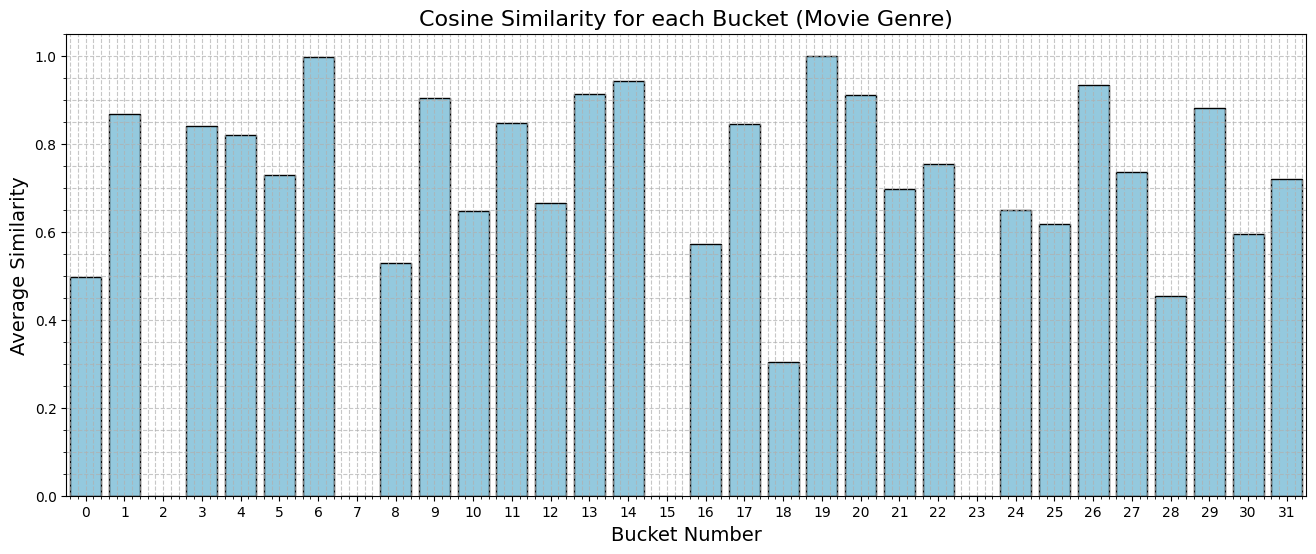

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mticker # Import the ticker module

# Collect the cosine similarity values
bucket_labels = [i for i in range(len(average_similarities_list))]

# Create a Pandas DataFrame from the data
data = {'Bucket': bucket_labels, 'Average Similarity': average_similarities_list}
df = pd.DataFrame(data)

# Plot the histogram
plt.figure(figsize=(16, 6))
sns.barplot(x='Bucket', y='Average Similarity', data=df, color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Cosine Similarity for each Bucket (Movie Genre)', fontsize=16)
plt.xlabel('Bucket Number', fontsize=14)
plt.ylabel('Average Similarity', fontsize=14)

# Add dense grid for both major and minor ticks
plt.grid(True, which="both", linestyle="--", alpha=0.7)
plt.minorticks_on()

plt.show()

This plot represents the average cosine similarity scores between movies assigned to the same bucket of the hash table.
The x-axis shows the bucket number and the y-axis shows the cosine similarity values. It is shown that:
- The average similarity values of most of the movies are above 0.6 meaning that using only the genre attribute, the hashing technique effectively groups similar movies together.
- There are some buckets with lower similarity values, indicating that certain that some movies do not fit into a single group because they are identified by multiple genres.
- A few buckets reach similarity values close to 1, which suggests that movies in these buckets share very strong genre-based relationships.






With the following code, the similarities between movies assigned to the bucket with highest similarity are computed.
Specifically the following informations are printed: Movie Name 1, Movie Name 2, Genres Movie 1, Genres Movie 2, Common Tokens and Similarity.
In this test, the similarity is high because most of the movies shares a high amount of tokens and because there are not many type of genres to compare.


In [19]:
# Filter the dataset to get similarities greater than or equal to 0.8
similarities_subset_filtered = similarities_subset.filter(lambda x: x[1] >= 0.8).sortBy(lambda x: x[1], ascending=False)
similarity_dict = dict(similarities_subset_filtered.collect())

# Collect the keys
similarity_keys = similarity_dict.keys()
distinct_keys = set([key for pair in similarity_keys for key in pair])

# Extract the Movie Name
movies_dict = dict(id_names.filter(id_names["Id"].isin(distinct_keys)).collect())

# Extract the Common Tokens of each Movie
common_tokens_subset = similarities_token.filter(lambda x: x[0] in similarity_keys)
common_tokens_dict = dict(common_tokens_subset.collect())

# Extract the Distinct Tokens for each Movie
genres = load_data('genres.csv', GENRES_PATTERN)
genres = genres.map(lambda s: (s[0], s[1]))
tokenized_genres = genres.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_genres = tokenized_genres.map(lambda s: (s[0], s[1])).filter(lambda x: x[0] in distinct_keys).collect()
genres_dict = dict(tokenized_genres)

print("Similarity Values between film in the highest Average Similarity bucket")
for (key1, key2), tokens in common_tokens_dict.items():
    # Get the movie name
    movie1 = movies_dict.get(int(key1), 'Unknown Movie')
    movie2 = movies_dict.get(int(key2), 'Unknown Movie')
    # Get the data for different movie
    tokens_movie1 = genres_dict.get(key1, 'Unknown Tokens')
    tokens_movie2 = genres_dict.get(key2, 'Unknown Tokens')
    # get the similarity
    similarity = similarity_dict.get((key1, key2), 'Unknown Similarity')

    # Print the information for each pair of movies and their common tokens
    print(f"Movie1: {movie1} ({key1})")
    print(f"Movie2: {movie2} ({key2})")
    print(f"Tokens Movie1: {tokens_movie1}")
    print(f"Tokens Movie2: {tokens_movie2}")
    print(f"Common Tokens: {', '.join(tokens)}")
    print(f"Similarity: {similarity}\n")

Similarity Values between film in the highest Average Similarity bucket
Movie1: The Viking Sagas (1120685)
Movie2: Man-Eater of Kumaon (1168336)
Tokens Movie1: ['action', 'adventure']
Tokens Movie2: ['adventure', 'action']
Common Tokens: adventure, action
Similarity: 1.0000000000000002

Movie1: Man-Eater of Kumaon (1168336)
Movie2: The Fallen (1453360)
Tokens Movie1: ['adventure', 'action']
Tokens Movie2: ['action', 'adventure']
Common Tokens: adventure, action
Similarity: 1.0000000000000002

Movie1: The Last from Philippines (1185532)
Movie2: Ninja in Ancient China (1217542)
Tokens Movie1: ['action', 'adventure']
Tokens Movie2: ['action', 'adventure']
Common Tokens: adventure, action
Similarity: 1.0000000000000002

Movie1: The Last from Philippines (1185532)
Movie2: I Piombi di Venezia (1361279)
Tokens Movie1: ['action', 'adventure']
Tokens Movie2: ['adventure', 'action']
Common Tokens: adventure, action
Similarity: 1.0000000000000002

Movie1: The Last from Philippines (1185532)
Movie

As can be seen from the printed data, all the movies resulting in this bucket shares the same genre and the similarity is 100%. With the next test new inforations are added to the dataset to distinguish movies using more attributes and not only their genres.

### 7.2. Similarity based on Movie Genre and Theme

In this section, more informations are aggregated to the dataset. The similarity between movies is done comparing the Movie Genre and Theme. After constructing the hash table, the average cosine similarity between movies in the same bucket is computed and the result is shown in the plot below.

In [20]:
# 1.1 - Load the .csv files in the Distributed File System in the following format: ('MovieId', 'Attributes')
genres = load_data('genres.csv', GENRES_PATTERN)
themes = load_data('themes.csv', THEMES_PATTERN)

# 1.2 - Converting data from ('MovieId', 'Attributes') to ('MovieId', [token list]) format
genres = genres.map(lambda s: (s[0], s[1]))
themes = themes.map(lambda s: (s[0], s[1]))
tokenized_genres = genres.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_themes = themes.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)

# 1.3 - Joining the data in a Combined Dataset used to compute similarity (in this case no joining)
combined_dataset = tokenized_genres.join(tokenized_themes).map(lambda x: (x[0], x[1][0] + x[1][1]))

# 2.1 - Create a corpus of document and compute the idfs
idfs_corpus = tokenized_genres.union(tokenized_themes)
idfs_values = idfs(idfs_corpus)
idfs_values_weights = idfs_values.collectAsMap()
idfs_values_broadcast = sc.broadcast(idfs_values_weights)

# 2.2 - Assign the tf.idf weight to each token in the Combined Dataset
tfidf_combined_dataset = combined_dataset.map(lambda s: (s[0], tfidf(s[1], idfs_values_broadcast.value)))
tfidf_values_broadcast = sc.broadcast(tfidf_combined_dataset.collectAsMap())


# 3.1 - Compute the Sparse TF-IDF matrix
tfidf_vocab = tfidf_combined_dataset.flatMap(lambda s: set(s[1])).distinct()
token_to_index_map = tfidf_vocab.zipWithIndex().collectAsMap()
token_index_broadcast = sc.broadcast(token_to_index_map)
vocab_size = tfidf_vocab.count()
tfidf_sparse_vectors = tfidf_combined_dataset.map(lambda x: (x[0], to_sparse_vector(x[1], vocab_size, token_index_broadcast)))

# 3.2 - Compute the hyperplanes
hash_length = 5
random_hyperplanes = generate_random_hyperplanes(vocab_size, hash_length)
random_hyperplanes_broadcast = sc.broadcast(random_hyperplanes)

# 3.3/3.4 - Compute the hash table
hash_table = tfidf_sparse_vectors.map(
    lambda x: (
        bin_to_int(compute_hashes(x[1], random_hyperplanes_broadcast.value)),  # Convert the binary hash vector to an integer
        (x[0])                                                                 # Movie ID
    )
)

hash_table = hash_table.groupByKey()
average_similarities_list = []

print("Average Cosine Similarities")
max_similarity = 0
for bucket_id in range(2**hash_length):
    # 4.1 Filter the Movie Ids from one bucket and select the their TF-IDF
    bucket_list = hash_table.filter(lambda x: x[0] == bucket_id).mapValues(list)
    movie_ids = bucket_list.flatMap(lambda x: x[1]).collect()
    filtered_tfidf_dataset = tfidf_combined_dataset.filter(lambda x: x[0] in set(movie_ids))

    # 4.2 - Invert the TF-IDF weights
    inverted_tfidf_dataset = (filtered_tfidf_dataset.flatMap(lambda r: invert(r)).cache())

    # 4.3 - Identifying Common Tokens between Movie Records
    common_tokens = (inverted_tfidf_dataset
                    .join(inverted_tfidf_dataset)
                    .map(lambda r: swap(r)))

    # 4.4 - Avoid record with the same key and also key with same moviIds but inverted
    common_tokens = (common_tokens
                    .filter(lambda r: r[0][0] != r[0][1])         # Ensure keys are different
                    .map(lambda r: (tuple(sorted(r[0])), r[1]))   # Sort the key to normalize
                    .distinct()                                   # Remove possible duplicates
                    .groupByKey()
                    .mapValues(list)
                    .cache())

    # 5.1 - Compute the norm of each record of the Combined Dataset
    norm_combined_dataset = tfidf_combined_dataset.map(lambda s: (s[0], norm(s[1])))
    norm_values_broadcast = sc.broadcast(norm_combined_dataset.collectAsMap())

    # 5.2 - Compute the fast cosine similarity between the records of the Combined Dataset
    similarities_combined_dataset = (common_tokens
                        .map(lambda r: fast_cosine_similarity(r, tfidf_values_broadcast, norm_values_broadcast ))
                        .cache())

    similarity_values = similarities_combined_dataset.map(lambda x: x[1])   # Extract similarity values
    average_similarity = similarity_values.mean()                           # Compute the average
    average_similarities_list.append(average_similarity)

    if average_similarity > max_similarity:
        similarities_subset = similarities_combined_dataset
        similarities_token = common_tokens
        max_similarity = average_similarity

    #Print the result
    print(f"Bucket: {bucket_id}, Average Similarity: {average_similarity:.5f}")

Average Cosine Similarities
Bucket: 0, Average Similarity: 0.70005
Bucket: 1, Average Similarity: 0.27151
Bucket: 2, Average Similarity: 0.30472
Bucket: 3, Average Similarity: 0.35329
Bucket: 4, Average Similarity: 0.36409
Bucket: 5, Average Similarity: 0.30060
Bucket: 6, Average Similarity: 0.32044
Bucket: 7, Average Similarity: 0.57349
Bucket: 8, Average Similarity: 0.88046
Bucket: 9, Average Similarity: 0.20766
Bucket: 10, Average Similarity: 0.33392
Bucket: 11, Average Similarity: 0.36542
Bucket: 12, Average Similarity: 0.00000
Bucket: 13, Average Similarity: 0.24247
Bucket: 14, Average Similarity: 0.58659
Bucket: 15, Average Similarity: 0.30477
Bucket: 16, Average Similarity: 0.00000
Bucket: 17, Average Similarity: 0.48809
Bucket: 18, Average Similarity: 0.37996
Bucket: 19, Average Similarity: 0.46973
Bucket: 20, Average Similarity: 0.49992
Bucket: 21, Average Similarity: 0.28598
Bucket: 22, Average Similarity: 0.00000
Bucket: 23, Average Similarity: 0.26706
Bucket: 24, Average Si

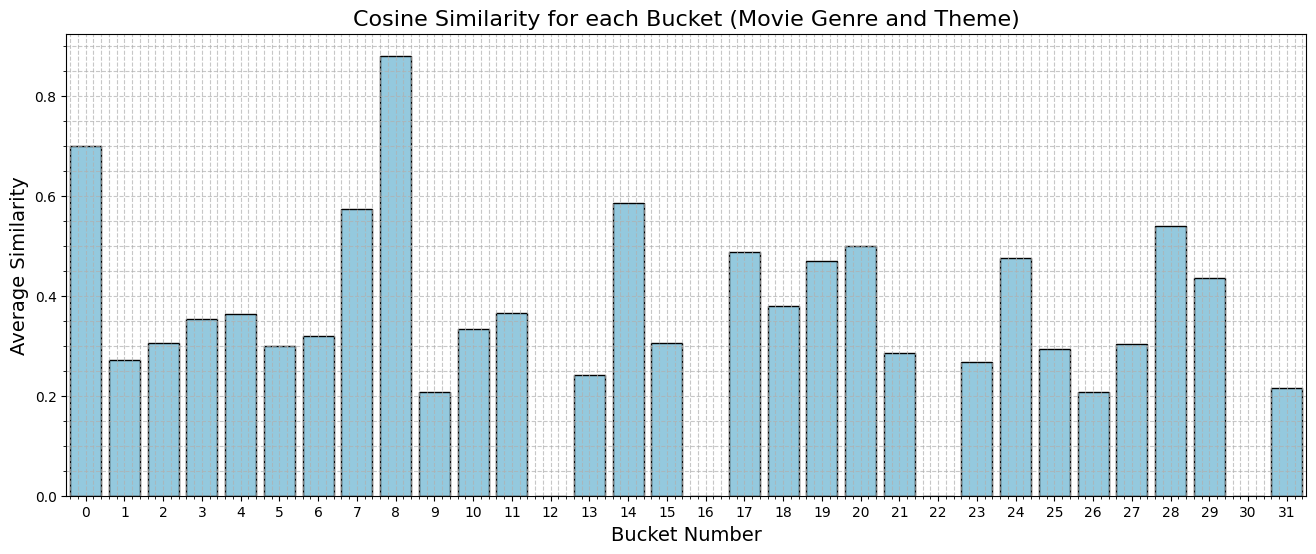

In [21]:
# Collect the cosine similarity values
bucket_labels = [i for i in range(len(average_similarities_list))]

# Create a Pandas DataFrame from the data
data = {'Bucket': bucket_labels, 'Average Similarity': average_similarities_list}
df = pd.DataFrame(data)

# Plot the histogram
plt.figure(figsize=(16, 6))
sns.barplot(x='Bucket', y='Average Similarity', data=df, color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Cosine Similarity for each Bucket (Movie Genre and Theme)', fontsize=16)
plt.xlabel('Bucket Number', fontsize=14)
plt.ylabel('Average Similarity', fontsize=14)

# Add dense grid for both major and minor ticks
plt.grid(True, which="both", linestyle="--", alpha=0.7)
plt.minorticks_on()

plt.show()

This plot represents the average cosine similarity scores between movies assigned to the same bucket of the hash table. The x-axis shows the bucket number and the y-axis shows the cosine similarity values. It is shown that:

- The average similarity values of most of the movies are above 0.6 meaning that using only the genre attribute, the hashing technique effectively groups similar movies together.
- There are some buckets with lower similarity values, indicating that certain that some movies do not fit into a single group because they are identified by multiple genres.
- A few buckets reach similarity values close to 1, which suggests that movies in these buckets share very strong genre-based relationships.

In the following code, the movies grouped in the highest similarity bucket are retrieved
and the similarity between them is computed. Specifically the following details are
printed: Movie Name 1, Movie name 2, Tokens Movie 1, Tokens Movie 2, Common
Tokens and Similarity. In this test, the inspected bucket has an average cosine similarity
of 0.88 but contains only three movies (compared to over 50 in the first test). This
indicates that these movies are strongly connected, sharing most of their theme and
genre tokens, but only a few of them exhibit extremely high similarity.


In [22]:
# Filter the dataset to get similarities greater than or equal to 0
similarities_subset_filtered = similarities_subset.filter(lambda x: x[1] >= 0).sortBy(lambda x: x[1], ascending=False)
similarity_dict = dict(similarities_subset_filtered.collect())

# Collect the keys
similarity_keys = similarity_dict.keys()
distinct_keys = set([key for pair in similarity_keys for key in pair])

# Extract the Movie Name
movies_dict = dict(id_names.filter(id_names["Id"].isin(distinct_keys)).collect())

# Extract the Common Tokens of each Movie
common_tokens_subset = similarities_token.filter(lambda x: x[0] in similarity_keys)
common_tokens_dict = dict(common_tokens_subset.collect())

# Extract the Distinct Tokens for each Movie
genres = load_data('genres.csv', GENRES_PATTERN)
themes = load_data('themes.csv', THEMES_PATTERN)
genres = genres.map(lambda s: (s[0], s[1]))
themes = themes.map(lambda s: (s[0], s[1]))
tokenized_genres = genres.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_genres = tokenized_genres.map(lambda s: (s[0], s[1])).filter(lambda x: x[0] in distinct_keys).collect()
tokenized_themes = themes.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_themes = tokenized_themes.map(lambda s: (s[0], s[1])).filter(lambda x: x[0] in distinct_keys).collect()
genres_dict = dict(tokenized_genres)
themes_dict = dict(tokenized_themes)

print("Similarity Values between film in the highest Average Similarity bucket")
for (key1, key2), tokens in common_tokens_dict.items():
    # Get the movie name
    movie1 = movies_dict.get(int(key1), 'Unknown Movie')
    movie2 = movies_dict.get(int(key2), 'Unknown Movie')
    # Get the data for different movie
    genres_movie1 = genres_dict.get(key1, 'Unknown Tokens')
    genres_movie2 = genres_dict.get(key2, 'Unknown Tokens')
    themes_movie1 = themes_dict.get(key1, 'Unknown Tokens')
    themes_movie2 = themes_dict.get(key2, 'Unknown Tokens')
    tokens_movie1 = genres_movie1 + themes_movie1
    tokens_movie2 = genres_movie2 + themes_movie2
    # get the similarity
    similarity = similarity_dict.get((key1, key2), 'Unknown Similarity')

    # Print the information for each pair of movies and their common tokens
    print(f"Movie1: {movie1} ({key1})")
    print(f"Movie2: {movie2} ({key2})")
    print(f"Tokens Movie1: {tokens_movie1}")
    print(f"Tokens Movie2: {tokens_movie2}")
    print(f"Common Tokens: {', '.join(tokens)}")
    print(f"Similarity: {similarity}\n")

Similarity Values between film in the highest Average Similarity bucket
Movie1: 27 Dresses (1001209)
Movie2: Something's Gotta Give (1003344)
Tokens Movie1: ['romance', 'comedy', 'relationship', 'comedy', 'crude', 'humor', 'satire', 'laugh-out-loud', 'relationship', 'entanglements', 'charming', 'romances', 'delightful', 'chemistry', 'quirky', 'endearing', 'relationships', 'touching', 'sentimental', 'family', 'stories', 'catchy', 'songs', 'hilarious', 'musical', 'comedy']
Tokens Movie2: ['romance', 'comedy', 'drama', 'relationship', 'comedy', 'crude', 'humor', 'satire', 'moving', 'relationship', 'stories', 'charming', 'romances', 'delightful', 'chemistry', 'laugh-out-loud', 'relationship', 'entanglements', 'quirky', 'endearing', 'relationships', 'touching', 'sentimental', 'family', 'stories', 'captivating', 'relationships', 'charming', 'romance']
Common Tokens: relationship, delightful, chemistry, family, humor, satire, charming, laugh-out-loud, relationships, entanglements, endearing, 

### 7.3. Similarity based on Movie Name, Genre and Theme

In this section, more informations are aggregated to the dataset. The similarity between movies is done comparing the Movie Name, Genre and Theme.  After constructing the hash table, the average cosine similarity between movies in the same bucket is computed and the result is shown in the plot below.

In [23]:
# 1.1 - Load the .csv files in the Distributed File System in the following format: ('MovieId', 'Attributes')
movies = load_data('movies.csv', MOVIES_PATTERN)
genres = load_data('genres.csv', GENRES_PATTERN)
themes = load_data('themes.csv', THEMES_PATTERN)

# 1.2 - Converting data from ('MovieId', 'Attributes') to ('MovieId', [token list]) format
movies = movies.map(lambda s: (s[0], s[1]))
genres = genres.map(lambda s: (s[0], s[1]))
themes = themes.map(lambda s: (s[0], s[1]))
tokenized_movies = movies.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_genres = genres.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_themes = themes.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)

# 1.3 - Joining the data in a Combined Dataset used to compute similarity (in this case no joining)
combined_dataset = tokenized_genres.join(tokenized_themes).map(lambda x: (x[0], x[1][0] + x[1][1]))
combined_dataset = combined_dataset.join(tokenized_movies).map(lambda x: (x[0], x[1][0] + x[1][1]))

# 2.1 - Create a corpus of document and compute the idfs
idfs_corpus = tokenized_genres.union(tokenized_themes).union(tokenized_movies)
idfs_values = idfs(idfs_corpus)
idfs_values_weights = idfs_values.collectAsMap()
idfs_values_broadcast = sc.broadcast(idfs_values_weights)

# 2.2 - Assign the tf.idf weight to each token in the Combined Dataset
tfidf_combined_dataset = combined_dataset.map(lambda s: (s[0], tfidf(s[1], idfs_values_broadcast.value)))
tfidf_values_broadcast = sc.broadcast(tfidf_combined_dataset.collectAsMap())

# 3.1 - Compute the Sparse TF-IDF matrix
tfidf_vocab = tfidf_combined_dataset.flatMap(lambda s: set(s[1])).distinct()
token_to_index_map = tfidf_vocab.zipWithIndex().collectAsMap()
token_index_broadcast = sc.broadcast(token_to_index_map)
vocab_size = tfidf_vocab.count()
tfidf_sparse_vectors = tfidf_combined_dataset.map(lambda x: (x[0], to_sparse_vector(x[1], vocab_size, token_index_broadcast)))

# 3.2 - Compute the hyperplanes
hash_length = 5
random_hyperplanes = generate_random_hyperplanes(vocab_size, hash_length)
random_hyperplanes_broadcast = sc.broadcast(random_hyperplanes)

# 3.3/3.4 - Compute the hash table
hash_table = tfidf_sparse_vectors.map(
    lambda x: (
        bin_to_int(compute_hashes(x[1], random_hyperplanes_broadcast.value)),  # Convert the binary hash vector to an integer
        (x[0])                                                                 # Movie ID
    )
)

hash_table = hash_table.groupByKey()
average_similarities_list = []

print("Average Cosine Similarities")
max_similarity = 0
for bucket_id in range(2**hash_length):
    # 4.1 Filter the Movie Ids from one bucket and select the their TF-IDF
    bucket_list = hash_table.filter(lambda x: x[0] == bucket_id).mapValues(list)
    movie_ids = bucket_list.flatMap(lambda x: x[1]).collect()
    filtered_tfidf_dataset = tfidf_combined_dataset.filter(lambda x: x[0] in set(movie_ids))

    # 4.2 - Invert the TF-IDF weights
    inverted_tfidf_dataset = (filtered_tfidf_dataset.flatMap(lambda r: invert(r)).cache())

    # 4.3 - Identifying Common Tokens between Movie Records
    common_tokens = (inverted_tfidf_dataset
                    .join(inverted_tfidf_dataset)
                    .map(lambda r: swap(r)))

    # 4.4 - Avoid record with the same key and also key with same moviIds but inverted
    common_tokens = (common_tokens
                    .filter(lambda r: r[0][0] != r[0][1])         # Ensure keys are different
                    .map(lambda r: (tuple(sorted(r[0])), r[1]))   # Sort the key to normalize
                    .distinct()                                   # Remove possible duplicates
                    .groupByKey()
                    .mapValues(list)
                    .cache())

    # 5.1 - Compute the norm of each record of the Combined Dataset
    norm_combined_dataset = tfidf_combined_dataset.map(lambda s: (s[0], norm(s[1])))
    norm_values_broadcast = sc.broadcast(norm_combined_dataset.collectAsMap())

    # 5.2 - Compute the fast cosine similarity between the records of the Combined Dataset
    similarities_combined_dataset = (common_tokens
                        .map(lambda r: fast_cosine_similarity(r, tfidf_values_broadcast, norm_values_broadcast ))
                        .cache())

    similarity_values = similarities_combined_dataset.map(lambda x: x[1])   # Extract similarity values
    average_similarity = similarity_values.mean()                           # Compute the average
    average_similarities_list.append(average_similarity)

    if average_similarity > max_similarity:
        similarities_subset = similarities_combined_dataset
        similarities_token = common_tokens
        max_similarity = average_similarity

    #Print the result
    print(f"Bucket: {bucket_id}, Average Similarity: {average_similarity:.5f}")

Average Cosine Similarities
Bucket: 0, Average Similarity: 0.65713
Bucket: 1, Average Similarity: 0.00000
Bucket: 2, Average Similarity: 0.61831
Bucket: 3, Average Similarity: 0.47205
Bucket: 4, Average Similarity: 0.00437
Bucket: 5, Average Similarity: 0.25708
Bucket: 6, Average Similarity: 0.13348
Bucket: 7, Average Similarity: 0.12756
Bucket: 8, Average Similarity: 0.00000
Bucket: 9, Average Similarity: 0.01273
Bucket: 10, Average Similarity: 0.00000
Bucket: 11, Average Similarity: 0.32858
Bucket: 12, Average Similarity: 0.00000
Bucket: 13, Average Similarity: 0.11095
Bucket: 14, Average Similarity: 0.00000
Bucket: 15, Average Similarity: 0.15452
Bucket: 16, Average Similarity: 0.14663
Bucket: 17, Average Similarity: 0.50350
Bucket: 18, Average Similarity: 0.23345
Bucket: 19, Average Similarity: 0.17672
Bucket: 20, Average Similarity: 0.29710
Bucket: 21, Average Similarity: 0.13718
Bucket: 22, Average Similarity: 0.44859
Bucket: 23, Average Similarity: 0.10051
Bucket: 24, Average Si

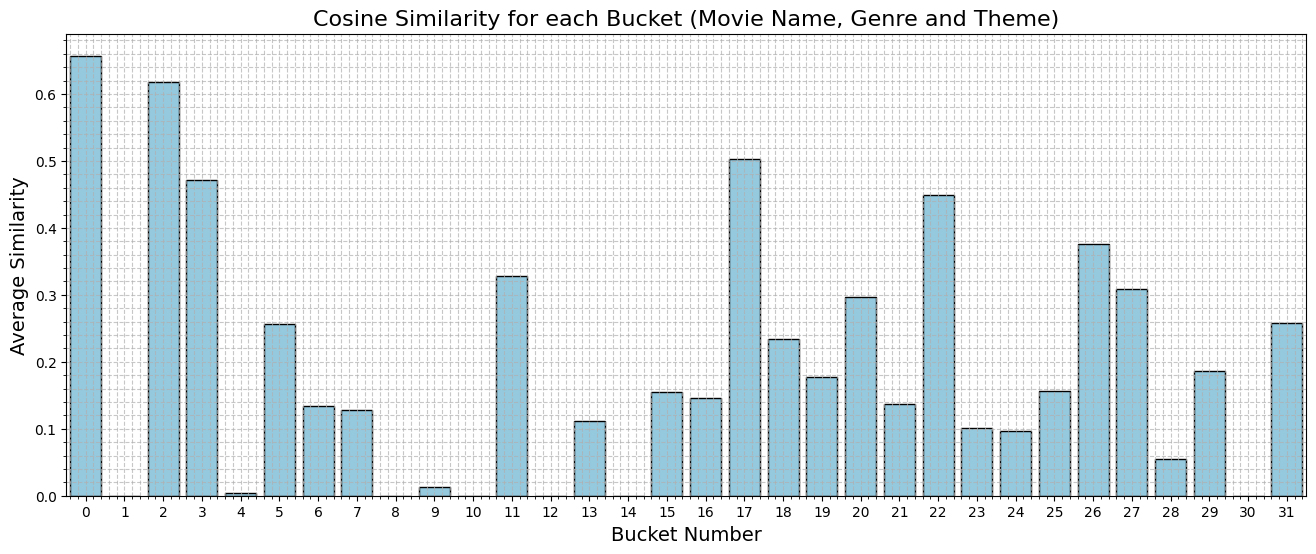

In [24]:
# Collect the cosine similarity values
bucket_labels = [i for i in range(len(average_similarities_list))]

# Create a Pandas DataFrame from the data
data = {'Bucket': bucket_labels, 'Average Similarity': average_similarities_list}
df = pd.DataFrame(data)

# Plot the histogram
plt.figure(figsize=(16, 6))
sns.barplot(x='Bucket', y='Average Similarity', data=df, color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Cosine Similarity for each Bucket (Movie Name, Genre and Theme)', fontsize=16)
plt.xlabel('Bucket Number', fontsize=14)
plt.ylabel('Average Similarity', fontsize=14)

# Add dense grid for both major and minor ticks
plt.grid(True, which="both", linestyle="--", alpha=0.7)
plt.minorticks_on()

plt.show()

This plot represents the average cosine similarity scores between movies assigned to the same bucket of the hash table. The x-axis shows the bucket number and the y-axis shows the cosine similarity values. It is shown that:
- The average similarity values of the list of movies belonging to the same buckets is
decreased from the last test because the Movie Name attribute has been added to
the dataset.
- There are some buckets with lower similarity values, but two buckets have a similarity value higher than 0.6. This suggest that movies in these buckets share very
strong relationships in terms of genre and themes.


In the following code the movies grouped in the highest similarity bucket are retrieved
and the similarity between them is computed.Specifically the following details are printed: Movie
Name 1, Movie name 2, Tokens Movie 1, Tokens Movie 2, Common Tokens and Similarity.
In this test, the inspected bucket has an average cosine similarity of 0.61 but contains
only three movies. This indicates that these movies are strongly connected and share most of their theme and genre tokens. Additionally, none of the common tokens include
the movie title, demonstrating that adding an attribute with a unique value for most
movies does not impact the similarity score

In [25]:
# Filter the dataset to get similarities greater than or equal to 0
similarities_subset_filtered = similarities_subset.filter(lambda x: x[1] >= 0).sortBy(lambda x: x[1], ascending=False)
similarity_dict = dict(similarities_subset_filtered.collect())

# Collect the keys
similarity_keys = similarity_dict.keys()
distinct_keys = set([key for pair in similarity_keys for key in pair])

# Extract the Movie Name
movies_dict = dict(id_names.filter(id_names["Id"].isin(distinct_keys)).collect())

# Extract the Common Tokens of each Movie
common_tokens_subset = similarities_token.filter(lambda x: x[0] in similarity_keys)
common_tokens_dict = dict(common_tokens_subset.collect())

# Extract the Distinct Tokens for each Movie
movies = load_data('movies.csv', MOVIES_PATTERN)
genres = load_data('genres.csv', GENRES_PATTERN)
themes = load_data('themes.csv', THEMES_PATTERN)
movies = movies.map(lambda s: (s[0], s[1]))
genres = genres.map(lambda s: (s[0], s[1]))
themes = themes.map(lambda s: (s[0], s[1]))
tokenized_movies = movies.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_movies = tokenized_movies.map(lambda s: (s[0], s[1])).filter(lambda x: x[0] in distinct_keys).collect()
tokenized_genres = genres.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_genres = tokenized_genres.map(lambda s: (s[0], s[1])).filter(lambda x: x[0] in distinct_keys).collect()
tokenized_themes = themes.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_themes = tokenized_themes.map(lambda s: (s[0], s[1])).filter(lambda x: x[0] in distinct_keys).collect()
movies_data_dict = dict(tokenized_movies)
genres_dict = dict(tokenized_genres)
themes_dict = dict(tokenized_themes)

print("Similarity Values between film in the highest Average Similarity bucket")
for (key1, key2), tokens in common_tokens_dict.items():
    # Get the movie name
    movie1 = movies_dict.get(int(key1), 'Unknown Movie')
    movie2 = movies_dict.get(int(key2), 'Unknown Movie')
    # Get the data for different movie
    data_movie1 = movies_data_dict.get(key1, 'Unknown Tokens')
    data_movie2 = movies_data_dict.get(key2, 'Unknown Tokens')
    genres_movie1 = genres_dict.get(key1, 'Unknown Tokens')
    genres_movie2 = genres_dict.get(key2, 'Unknown Tokens')
    themes_movie1 = themes_dict.get(key1, 'Unknown Tokens')
    themes_movie2 = themes_dict.get(key2, 'Unknown Tokens')
    tokens_movie1 = genres_movie1 + themes_movie1 + data_movie1
    tokens_movie2 = genres_movie2 + themes_movie2 + data_movie2
    # get the similarity
    similarity = similarity_dict.get((key1, key2), 'Unknown Similarity')

    # Print the information for each pair of movies and their common tokens
    print(f"Movie1: {movie1} ({key1})")
    print(f"Movie2: {movie2} ({key2})")
    print(f"Tokens Movie1: {tokens_movie1}")
    print(f"Tokens Movie2: {tokens_movie2}")
    print(f"Common Tokens: {', '.join(tokens)}")
    print(f"Similarity: {similarity}\n")

Similarity Values between film in the highest Average Similarity bucket
Movie1: Baghead (1007867)
Movie2: The Man Who Haunted Himself (1025655)
Tokens Movie1: ['horror', 'gothic', 'eerie', 'haunting', 'horror', 'twisted', 'dark', 'psychological', 'thriller', 'baghead']
Tokens Movie2: ['drama', 'thriller', 'gothic', 'eerie', 'haunting', 'horror', 'twisted', 'dark', 'psychological', 'thriller', 'man', 'haunted']
Common Tokens: haunting, gothic, psychological, twisted, dark, horror, thriller, eerie
Similarity: 0.6983823817017383

Movie1: Baghead (1007867)
Movie2: One Missed Call (1008155)
Tokens Movie1: ['horror', 'gothic', 'eerie', 'haunting', 'horror', 'twisted', 'dark', 'psychological', 'thriller', 'baghead']
Tokens Movie2: ['horror', 'thriller', 'mystery', 'gothic', 'eerie', 'haunting', 'horror', 'twisted', 'dark', 'psychological', 'thriller', 'one', 'missed', 'call']
Common Tokens: gothic, psychological, haunting, twisted, dark, eerie, thriller, horror
Similarity: 0.6404184882285577


### 7.4. Similarity based on Movie Name, Genre, Theme and Description

In this section, more informations are aggregated to the dataset. The similarity between movies is done comparing the Movie Name, Genre, Theme and Description. After constructing the hash table, the average cosine similarity between movies in the same bucket is computed and the result is shown in the plot below.

In [26]:
# 1.1 - Load the .csv files in the Distributed File System in the following format: ('MovieId', 'Attributes')
movies = load_data('movies.csv', MOVIES_PATTERN)
genres = load_data('genres.csv', GENRES_PATTERN)
themes = load_data('themes.csv', THEMES_PATTERN)

# 1.2 - Converting data from ('MovieId', 'Attributes') to ('MovieId', [token list]) format
movies = movies.map(lambda s: (s[0], s[1]+s[4]))
genres = genres.map(lambda s: (s[0], s[1]))
themes = themes.map(lambda s: (s[0], s[1]))
tokenized_movies = movies.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_genres = genres.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_themes = themes.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)

# 1.3 - Joining the data in a Combined Dataset used to compute similarity (in this case no joining)
combined_dataset = tokenized_genres.join(tokenized_themes).map(lambda x: (x[0], x[1][0] + x[1][1]))
combined_dataset = combined_dataset.join(tokenized_movies).map(lambda x: (x[0], x[1][0] + x[1][1]))

# 2.1 - Create a corpus of document and compute the idfs
idfs_corpus = tokenized_genres.union(tokenized_themes).union(tokenized_movies)
idfs_values = idfs(idfs_corpus)
idfs_values_weights = idfs_values.collectAsMap()
idfs_values_broadcast = sc.broadcast(idfs_values_weights)

# 2.2 - Assign the tf.idf weight to each token in the Combined Dataset
tfidf_combined_dataset = combined_dataset.map(lambda s: (s[0], tfidf(s[1], idfs_values_broadcast.value)))
tfidf_values_broadcast = sc.broadcast(tfidf_combined_dataset.collectAsMap())

# 3.1 - Compute the Sparse TF-IDF matrix
tfidf_vocab = tfidf_combined_dataset.flatMap(lambda s: set(s[1])).distinct()
token_to_index_map = tfidf_vocab.zipWithIndex().collectAsMap()
token_index_broadcast = sc.broadcast(token_to_index_map)
vocab_size = tfidf_vocab.count()
tfidf_sparse_vectors = tfidf_combined_dataset.map(lambda x: (x[0], to_sparse_vector(x[1], vocab_size, token_index_broadcast)))

# 3.2 - Compute the hyperplanes
hash_length = 5
random_hyperplanes = generate_random_hyperplanes(vocab_size, hash_length)
random_hyperplanes_broadcast = sc.broadcast(random_hyperplanes)

# 3.3/3.4 - Compute the hash table
hash_table = tfidf_sparse_vectors.map(
    lambda x: (
        bin_to_int(compute_hashes(x[1], random_hyperplanes_broadcast.value)),  # Convert the binary hash vector to an integer
        (x[0])                                                                 # Movie ID
    )
)

hash_table = hash_table.groupByKey()
average_similarities_list = []

print("Average Cosine Similarities")
max_similarity = 0
for bucket_id in range(2**hash_length):
    # 4.1 Filter the Movie Ids from one bucket and select the their TF-IDF
    bucket_list = hash_table.filter(lambda x: x[0] == bucket_id).mapValues(list)
    movie_ids = bucket_list.flatMap(lambda x: x[1]).collect()
    filtered_tfidf_dataset = tfidf_combined_dataset.filter(lambda x: x[0] in set(movie_ids))

    # 4.2 - Invert the TF-IDF weights
    inverted_tfidf_dataset = (filtered_tfidf_dataset.flatMap(lambda r: invert(r)).cache())

    # 4.3 - Identifying Common Tokens between Movie Records
    common_tokens = (inverted_tfidf_dataset
                    .join(inverted_tfidf_dataset)
                    .map(lambda r: swap(r)))

    # 4.4 - Avoid record with the same key and also key with same moviIds but inverted
    common_tokens = (common_tokens
                    .filter(lambda r: r[0][0] != r[0][1])         # Ensure keys are different
                    .map(lambda r: (tuple(sorted(r[0])), r[1]))   # Sort the key to normalize
                    .distinct()                                   # Remove possible duplicates
                    .groupByKey()
                    .mapValues(list)
                    .cache())

    # 5.1 - Compute the norm of each record of the Combined Dataset
    norm_combined_dataset = tfidf_combined_dataset.map(lambda s: (s[0], norm(s[1])))
    norm_values_broadcast = sc.broadcast(norm_combined_dataset.collectAsMap())

    # 5.2 - Compute the fast cosine similarity between the records of the Combined Dataset
    similarities_combined_dataset = (common_tokens
                        .map(lambda r: fast_cosine_similarity(r, tfidf_values_broadcast, norm_values_broadcast ))
                        .cache())

    similarity_values = similarities_combined_dataset.map(lambda x: x[1])   # Extract similarity values
    average_similarity = similarity_values.mean()                           # Compute the average
    average_similarities_list.append(average_similarity)

    if average_similarity > max_similarity:
        similarities_subset = similarities_combined_dataset
        similarities_token = common_tokens
        max_similarity = average_similarity

    #Print the result
    print(f"Bucket: {bucket_id}, Average Similarity: {average_similarity:.5f}")

Average Cosine Similarities
Bucket: 0, Average Similarity: 0.07173
Bucket: 1, Average Similarity: 0.00000
Bucket: 2, Average Similarity: 0.05386
Bucket: 3, Average Similarity: 0.03192
Bucket: 4, Average Similarity: 0.00985
Bucket: 5, Average Similarity: 0.13413
Bucket: 6, Average Similarity: 0.02417
Bucket: 7, Average Similarity: 0.03361
Bucket: 8, Average Similarity: 0.04493
Bucket: 9, Average Similarity: 0.02982
Bucket: 10, Average Similarity: 0.01776
Bucket: 11, Average Similarity: 0.27173
Bucket: 12, Average Similarity: 0.08147
Bucket: 13, Average Similarity: 0.00648
Bucket: 14, Average Similarity: 0.01989
Bucket: 15, Average Similarity: 0.04793
Bucket: 16, Average Similarity: 0.07424
Bucket: 17, Average Similarity: 0.03318
Bucket: 18, Average Similarity: 0.01238
Bucket: 19, Average Similarity: 0.02328
Bucket: 20, Average Similarity: 0.05132
Bucket: 21, Average Similarity: 0.05112
Bucket: 22, Average Similarity: 0.13273
Bucket: 23, Average Similarity: 0.19356
Bucket: 24, Average Si

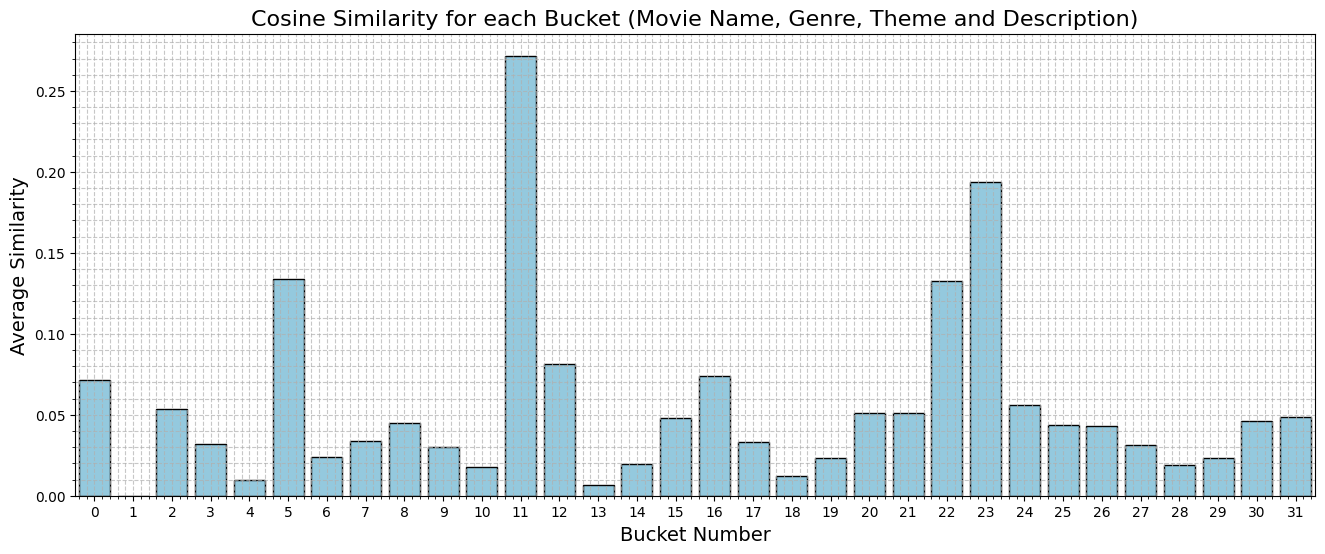

In [27]:
# Collect the cosine similarity values
bucket_labels = [i for i in range(len(average_similarities_list))]

# Create a Pandas DataFrame from the data
data = {'Bucket': bucket_labels, 'Average Similarity': average_similarities_list}
df = pd.DataFrame(data)

# Plot the histogram
plt.figure(figsize=(16, 6))
sns.barplot(x='Bucket', y='Average Similarity', data=df, color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Cosine Similarity for each Bucket (Movie Name, Genre, Theme and Description)', fontsize=16)
plt.xlabel('Bucket Number', fontsize=14)
plt.ylabel('Average Similarity', fontsize=14)

# Add dense grid for both major and minor ticks
plt.grid(True, which="both", linestyle="--", alpha=0.7)
plt.minorticks_on()

plt.show()

This plot represents the average cosine similarity scores between movies assigned to the same bucket of the hash table. The x-axis shows the bucket number and the y-axis shows the cosine similarity values.
It is shown that:
- Most of the average similarity values for movies within the same bucket are below 0.1. This indicates that adding the movie description makes it more difficult to
achieve a high average similarity for each record.
- However, one bucket has a similarity value greater than 0.25, suggesting that the
movies in this bucket share very strong connections in terms of genre, themes, and descriptions.


In the following code the movies grouped in the highest similarity bucket are retrieved and the similarity between them is computed. Specifically the following details are printed: Movie
Name 1, Movie name 2, Tokens Movie 1, Tokens Movie 2, Common Tokens and Similarity.
In this test, the inspected bucket has an average cosine similarity of 0.27 but contains
only two movies. This indicates that these movies are strongly connected and share most
of their theme, genre, and description tokens. The most influential tokens in determining
similarity are still the genre and theme tokens, as they contain the most relevant shared
information across all movies.

In [28]:
# Filter the dataset to get similarities greater than or equal to 0
similarities_subset_filtered = similarities_subset.filter(lambda x: x[1] >= 0).sortBy(lambda x: x[1], ascending=False)
similarity_dict = dict(similarities_subset_filtered.collect())

# Collect the keys
similarity_keys = similarity_dict.keys()
distinct_keys = set([key for pair in similarity_keys for key in pair])

# Extract the Movie Name
movies_dict = dict(id_names.filter(id_names["Id"].isin(distinct_keys)).collect())

# Extract the Common Tokens of each Movie
common_tokens_subset = similarities_token.filter(lambda x: x[0] in similarity_keys)
common_tokens_dict = dict(common_tokens_subset.collect())

# Extract the Distinct Tokens for each Movie
movies = load_data('movies.csv', MOVIES_PATTERN)
genres = load_data('genres.csv', GENRES_PATTERN)
themes = load_data('themes.csv', THEMES_PATTERN)
movies = movies.map(lambda s: (s[0], s[1]+s[4]))
genres = genres.map(lambda s: (s[0], s[1]))
themes = themes.map(lambda s: (s[0], s[1]))
tokenized_movies = movies.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_movies = tokenized_movies.map(lambda s: (s[0], s[1])).filter(lambda x: x[0] in distinct_keys).collect()
tokenized_genres = genres.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_genres = tokenized_genres.map(lambda s: (s[0], s[1])).filter(lambda x: x[0] in distinct_keys).collect()
tokenized_themes = themes.map(lambda s: (s[0], tokenize(s[1]))).reduceByKey(lambda a, b: a + b)
tokenized_themes = tokenized_themes.map(lambda s: (s[0], s[1])).filter(lambda x: x[0] in distinct_keys).collect()
movies_data_dict = dict(tokenized_movies)
genres_dict = dict(tokenized_genres)
themes_dict = dict(tokenized_themes)

print("Similarity Values between film in the highest Average Similarity bucket")
for (key1, key2), tokens in common_tokens_dict.items():
    # Get the movie name
    movie1 = movies_dict.get(int(key1), 'Unknown Movie')
    movie2 = movies_dict.get(int(key2), 'Unknown Movie')
    # Get the data for different movie
    data_movie1 = movies_data_dict.get(key1, 'Unknown Tokens')
    data_movie2 = movies_data_dict.get(key2, 'Unknown Tokens')
    genres_movie1 = genres_dict.get(key1, 'Unknown Tokens')
    genres_movie2 = genres_dict.get(key2, 'Unknown Tokens')
    themes_movie1 = themes_dict.get(key1, 'Unknown Tokens')
    themes_movie2 = themes_dict.get(key2, 'Unknown Tokens')
    tokens_movie1 = genres_movie1 + themes_movie1 + data_movie1
    tokens_movie2 = genres_movie2 + themes_movie2 + data_movie2
    # get the similarity
    similarity = similarity_dict.get((key1, key2), 'Unknown Similarity')

    # Print the information for each pair of movies and their common tokens
    print(f"Movie1: {movie1} ({key1})")
    print(f"Movie2: {movie2} ({key2})")
    print(f"Tokens Movie1: {tokens_movie1}")
    print(f"Tokens Movie2: {tokens_movie2}")
    print(f"Common Tokens: {', '.join(tokens)}")
    print(f"Similarity: {similarity}\n")

Similarity Values between film in the highest Average Similarity bucket
Movie1: Falling (1012814)
Movie2: American Heart (1032165)
Tokens Movie1: ['drama', 'moving', 'relationship', 'stories', 'heartbreaking', 'moving', 'family', 'drama', 'emotional', 'touching', 'family', 'dramas', 'powerful', 'stories', 'heartbreak', 'suffering', 'touching', 'sentimental', 'family', 'stories', 'fallingjohn', 'peterson', 'lives', 'partner', 'eric', 'adopted', 'daughter', 'southern', 'california', 'visited', 'aging', 'father', 'willis', 'los', 'angeles', 'searching', 'place', 'retire', 'two', 'different', 'worlds', 'collide']
Tokens Movie2: ['crime', 'underdogs', 'coming', 'age', 'violent', 'crime', 'drugs', 'heartbreaking', 'moving', 'family', 'drama', 'emotional', 'touching', 'family', 'dramas', 'enduring', 'stories', 'family', 'marital', 'drama', 'american', 'heartan', 'ex-convict', 'tracked', 'estranged', 'teenage', 'son', 'pair', 'try', 'build', 'relationship', 'life', 'together', 'seattle']
Commo